In [1]:
import os
import re
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from math import floor
from glob import glob
ROOT_PATH = os.path.abspath("..")

In [6]:
# Read data
raw_data_filenames = glob(os.path.join(ROOT_PATH, "assets/*.csv"))
raw_data_filenames.sort()


# Create DataFrame
df = pd.concat(
    [
        pd.read_csv(filename, delimiter=r"\s\s+", engine="python")
        for filename
        in raw_data_filenames
    ],
    axis=0,
    ignore_index=True,
)


# Remove repeating headers
df = df[df.NAME != "NAME"]


# Parse the data
def percentage_to_float(df_col):
    return df_col.apply(lambda x: float(x[0:-1]))

def split_on_slash(df_col, split_index):
    return df_col.apply(lambda x: x.split(" / ")[split_index])

def get_only_characters(string):
    return re.sub('[^a-zA-Z]+', '', string)

def get_only_numbers(string):
    return float(re.sub('[^\d\.]', '', string))

def to_bit(value):
    return int({
        "b": get_only_numbers(value) * 1,
        "kib": get_only_numbers(value) * 10e3,
        "kb": get_only_numbers(value) * 10e3,
        "mib": get_only_numbers(value) * 10e6,
        "mb": get_only_numbers(value) * 10e6,
        "gib": get_only_numbers(value) * 10e9,
        "gb": get_only_numbers(value) * 10e9,
    }.get(get_only_characters(value).lower(), 0))

df["mem_usage"] = split_on_slash(df["MEM USAGE / LIMIT"], 0).apply(to_bit)
df["mem_limit"] = split_on_slash(df["MEM USAGE / LIMIT"], 1).apply(to_bit)
df["mem_percentage"] = percentage_to_float(df["MEM %"])
df["cpu_percentage"] = percentage_to_float(df["CPU %"])
df["PIDS"] = df["PIDS"].apply(int)
df["net_in"] = split_on_slash(df["NET I/O"], 0).apply(to_bit)
df["net_out"] = split_on_slash(df["NET I/O"], 1).apply(to_bit)
df["block_in"] = split_on_slash(df["BLOCK I/O"], 0).apply(to_bit)
df["block_out"] = split_on_slash(df["BLOCK I/O"], 1).apply(to_bit)

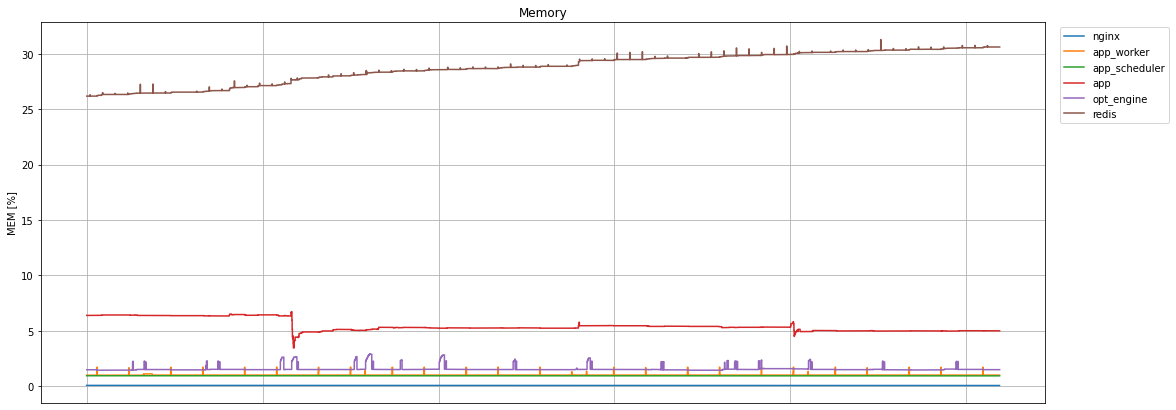

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18, 7))

sns.lineplot(x=df.index, y="mem_percentage", hue="NAME", data=df, drawstyle="steps")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel("MEM [%]")
plt.title(f"Memory")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()